# Autodiff

<img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo.svg" alt="JAX Logo" height ="50"/>

JAX is like numpy, but with autodiff. This means that you can compute gradients of functions with respect to their inputs.


<small>Other frameworks like TensorFlow, Pytorch also have autodiff</small>

## Simple Example

### Standart numpy

In [12]:
def f(x,y,z):
    return (x+y)*z

f(-2,5,-4)

-12

### Same with JAX

In [13]:
# Hack for Mac: Currently Nov 2025 problems with Metal backend
import os
os.environ["JAX_PLATFORMS"] = "cpu" 

import jax.numpy as jnp
from jax import grad

def g(x,y,z):
    return (x+y)*z

print(f'g(-2,5,-4) = {g(-2,5,-4)}')
print(f'grad(g)|(-2.,5.,-4.) = {grad(g)(-2.,5.,-4.)}')

g(-2,5,-4) = -12
grad(g)|(-2.,5.,-4.) = -4.0


In [14]:
### Second order derivatives
def gg(x):
    return x**4

print(f'{gg(2.)}')

ggg = grad(gg)
print(f'{ggg(2.)}')
print(f'{grad(ggg)(2.)}')

16.0
32.0
48.0


## Autodiff of functions (in a coding sense)

Autodiff is not limited to simple functions. You can compute gradients of complicated python functions with respect to their inputs.

### Calculating Sums with loops

Let's look at the following function:
$$
f(x) = \sum_{k=1}^{N} \left( \ln(x + k) - \ln(x + k - 1) \right)
$$

The derivative of this function w.r.t. $x$ is (feel free to try to derive it yourself):
$$
f^{\prime}(x) = -\frac{N}{x(x + N)} 
$$

Let's implement this function in a naive way and calculate the derivative using JAX.

In [15]:
import jax
import jax.numpy as jnp

def f(x, N):
    result = 0.0
    for k in range(1, N + 1):
        term = jnp.log(x + k) - jnp.log(x + k - 1)
        result += term
    return result

# Derivative respect to x, always uses the first argument
df_dx = jax.grad(f)

# Example values
x_value = 2.0
N_value = 5

df_dx(x_value, N_value), -5./14. # Should be -5/(2(2 + 5)) = -5/14  

(Array(-0.35714284, dtype=float32, weak_type=True), -0.35714285714285715)

# 🎓⬅️ Return to Lecture

## Custom functions / Idea of gradient calculation

The next examples shows how to JAX calulates the gradient. Every function needs to provide a gradient. For simple functions this is already implemented. Let's define a custom function in which we define the gradient ourselves. We take a look at the ReLU-like function, which is quadratic for positive values and 0 for negative values. We define the function as follows:


$$
\text{qlu}(x) = 
\begin{cases} 
x^2, & \text{if } x > 0 \\
0, & \text{if } x \leq 0 
\end{cases}
$$
Which is continuous everywhere except at 0 but the gradient is not defined at 0. We can define the gradient to be 0.42 at 0. The flowing diagram shows the function and its gradient. 

<center>
    <img src="qlu.svg" alt="QLU Diagram" height="100"/>
</center>

So the derivative of the function is:
$$
\text{qlu}^{\prime}(x) =
\begin{cases}
2x, & \text{if } x > 0 \\
0.42, & \text{if } x = 0 \\
0, & \text{if } x < 0
\end{cases}
$$


To be used in the "Chain Rule" we need to define the gradient of the function w.r.t. x. This is a function that takes the value of x and the "incomming gradient" grad_y and returns the gradient of the function w.r.t. x. 

Technically you need to define two functions.

* The forward pass. Which is the function $f(x)$ itself, which returns the output of the function $y$ **and** information needed for the backward pass. In the easiest case this is just the value of x.


* The backward pass. This takes as arguments the stored information of the forward pass and the incoming gradient `grad_y` and returns the gradient of the function w.r.t. x. 


In [6]:
import jax
from jax import custom_vjp
# Define the custom qlu function and state that, we provide custom gradients. 
# By defining the forward and backward functions.
@custom_vjp
def qlu(x):
    return jnp.where(x > 0, x**2, 0)    

# Forward function
def qlu_fwd(x):
    y = qlu(x) 
    return y, x  # Pass x to the backward fkt 

# Gradient is:
# 0 for x < 0
# 1 for x > 0
# 0.42 at x = 0

# Backward function
#  Local gradient * incoming gradient 
def qlu_bwd(x, grad_y):
    grad_x = jnp.where(x > 0, 2*x*grad_y, 0)                # Grad = x for x > 0 and 0 for x <= 0
    grad_x = jnp.where(x == 0, grad_y * 0.42, grad_x)       # Special case Grad = 0.42 for x == 0
    return (grad_x,)

# Register forward and backward pass
qlu.defvjp(qlu_fwd, qlu_bwd)

# Test the function and its gradient
x_values = jnp.array([-1.0, 0.0, 2.0])  # Test points
print("Custom ReLU values:", qlu(x_values))

# Compute gradients
grads = jax.grad(lambda x: qlu(x).sum())(x_values)
print("Gradients of Custom ReLU at test points:", grads)

Custom ReLU values: [0. 0. 4.]
Gradients of Custom ReLU at test points: [0.   0.42 4.  ]


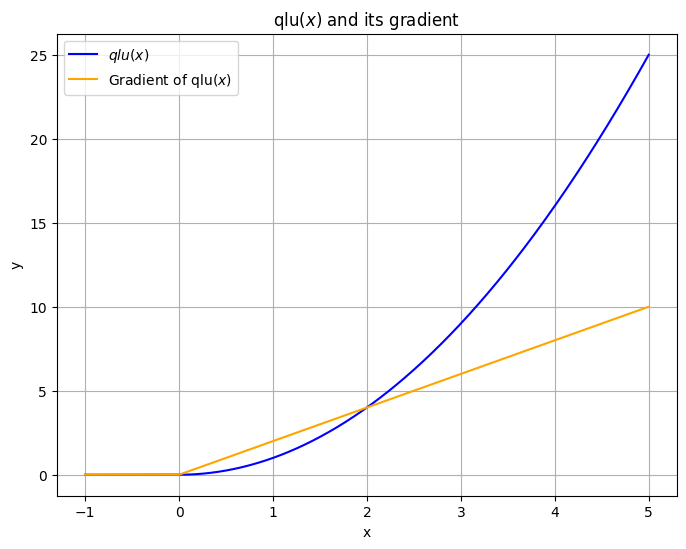

In [7]:
import matplotlib.pyplot as plt
# Generate x values
x = jnp.linspace(-1, 5, 1000)

y = qlu(x)
dy_dx = jax.vmap(jax.grad(lambda x: qlu(x)))(x)

# Plot the function and its gradient
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"${qlu}(x)$", color='blue')
plt.plot(x, dy_dx, label=r"Gradient of $\mathrm{qlu}(x)$", color='orange')
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"$\mathrm{qlu}(x)$ and its gradient")
plt.legend()
plt.grid(True)
plt.show()

Chain Rule rulez:
$$
f^{\prime}(x) = \frac{\mathrm{d}}{\mathrm{d}x} \sin(\mathrm{qlu}(x)) = \cos(\mathrm{qlu}(x)) \cdot \mathrm{qlu}^{\prime}(x)
$$

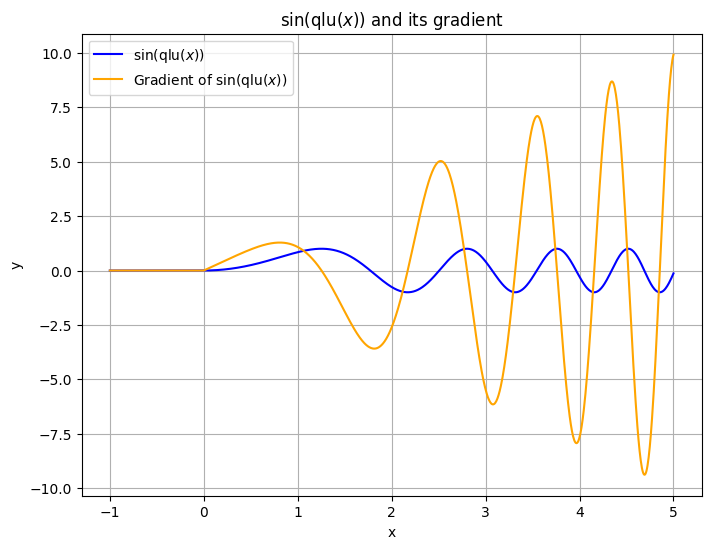

In [8]:

# Generate x values
x = jnp.linspace(-1, 5, 1000)

# Compute sin(qlu(x)) and its gradient
y = jnp.sin(qlu(x))
dy_dx = jax.vmap(jax.grad(lambda x: jnp.sin(qlu(x))))(x)

# Plot the function and its gradient
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"$\sin(\mathrm{qlu}(x))$", color='blue')
plt.plot(x, dy_dx, label=r"Gradient of $\sin(\mathrm{qlu}(x))$", color='orange')
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"$\sin(\mathrm{qlu}(x))$ and its gradient")
plt.legend()
plt.grid(True)
plt.show()